#  **Learning the Burgers' Equation with Convolutional Neural Operators (CNO)**

##  ***Introduction***

In this tutorial, we’ll learn how to **predict the solution of Burgers' equation** using a **Convolutional Neural Operator (CNO1d)**.

Instead of solving the equation using numerical solvers like finite differences or finite elements, we will train a deep learning model to **learn a mapping from one function to another**:

>$u(x, t=0) \longrightarrow u(x, t=1)$

This is a **supervised learning task**, where the **input** is the solution at initial time $ t = 0 $, and the **output** is the solution at final time $ t = 1 $. We'll train a neural operator (a neural network designed to operate on functions) to learn this behavior.

---

## ***What is Burgers' Equation?***

Burgers' equation is a fundamental **nonlinear partial differential equation (PDE)** given by:

> $
\frac{\partial u}{\partial t} + u \, \frac{\partial u}{\partial x} = \nu \, \frac{\partial^2 u}{\partial x^2}
$

where:
- $u(x, t) $ is the velocity field (or solution),
- $ \nu $ is the viscosity,
- $ x \in [-1, 1] $, the spatial domain,
- $ t \in [0, 1] $, the temporal domain.

It is commonly used to model **shock waves, fluid flow, and traffic flow**.

---

## ***Goal of the Tutorial***

We want to **train a machine learning model that can predict the final solution $ u(x, t=1) $** from the given initial condition $ u(x, t=0) $, without ever solving the PDE directly.

This is how you can think about it:

> Given a waveform at time $ t = 0 $, can a neural network learn to predict how that waveform evolves to time $ t = 1 $?

To do this, we'll use a **Convolutional Neural Operator (CNO1d)** – a special type of neural network that learns to map between entire functions rather than just scalar values.

---

##  ***Steps We Will Follow***

1. **Load Burgers' equation solution data**  
2. **Visualize the initial and final state of the system**  
3. **Build a simple 1D Convolutional Neural Operator (CNO1d)**  
4. **Train the model to learn the mapping: $ u(x, 0) \rightarrow u(x, 1) $**  
5. **Evaluate and visualize the prediction**  

---

## ***What We Will Learn***

- How to process function-based data (like \$ u(x, t) $)  
- How to define and train a neural operator model (CNO1d)  
- How to evaluate predictions of a function at a future time  

In [1]:
# Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

## **Step 01: Load the data**

In [3]:
# Path to your Burgers.npz file inside your Google Drive
file_path = '/content/drive/MyDrive/Colab_Notebooks/PINNs/Burgers_Equation/Burgers.npz'

# Load the data
data = np.load(file_path)
x = data["x"].flatten()
t = data["t"].flatten()
u = data["usol"]

print(f" x shape: {x.shape},\n t shape: {t.shape},\n u shape: {u.shape}")

 x shape: (256,),
 t shape: (100,),
 u shape: (256, 100)


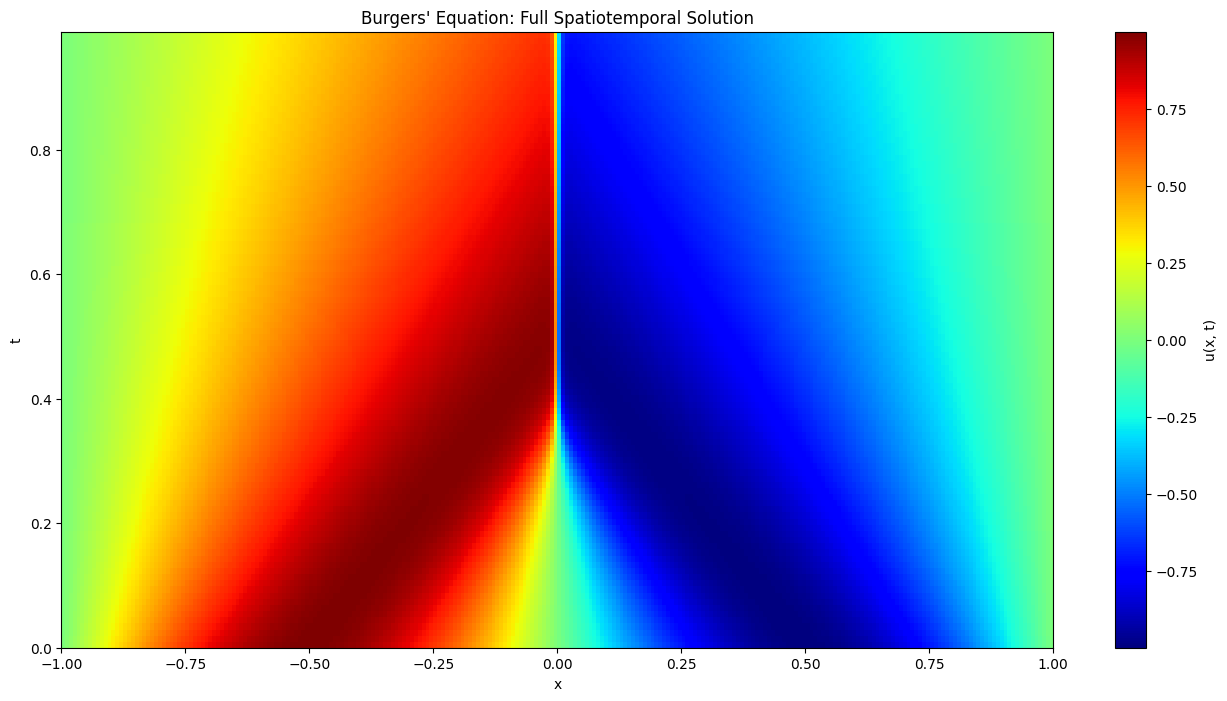

In [4]:
plt.figure(figsize=(16, 8))

# Plot as heatmap (space on x-axis, time on y-axis)
plt.imshow(u.T, extent=[x.min(), x.max(), t.min(), t.max()],
           aspect='auto', origin='lower', cmap='jet')

plt.colorbar(label="u(x, t)")
plt.xlabel("x")
plt.ylabel("t")
plt.title("Burgers' Equation: Full Spatiotemporal Solution")
plt.show()


We want to **learn a mapping** from the **initial condition** $ u(x, t = 0) $ to the **solution at final time** $ u(x, t = 1) $.

This is a **function-to-function** learning task:  
>Given $ u_0(x) = u(x, t = 0) $, predict $ u_1(x) = u(x, t = 1) $

## **Step 02: Inspect the Initial State function of $u (x, t=0)$ and Final State function $u(x, t =1)$**

In [5]:
# Convert initial and final states to tensors
u0 = u[:, 0]   # u(x, t=0)
u1 = u[:, -1]  # u(x, t=1)

# Convert to tensors and reshape for Conv1D input
X_tensor = torch.tensor(u0, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # shape: (1, 1, 256)
Y_tensor = torch.tensor(u1, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # shape: (1, 1, 256)

# Wrap in DataLoader
dataset = TensorDataset(X_tensor, Y_tensor)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

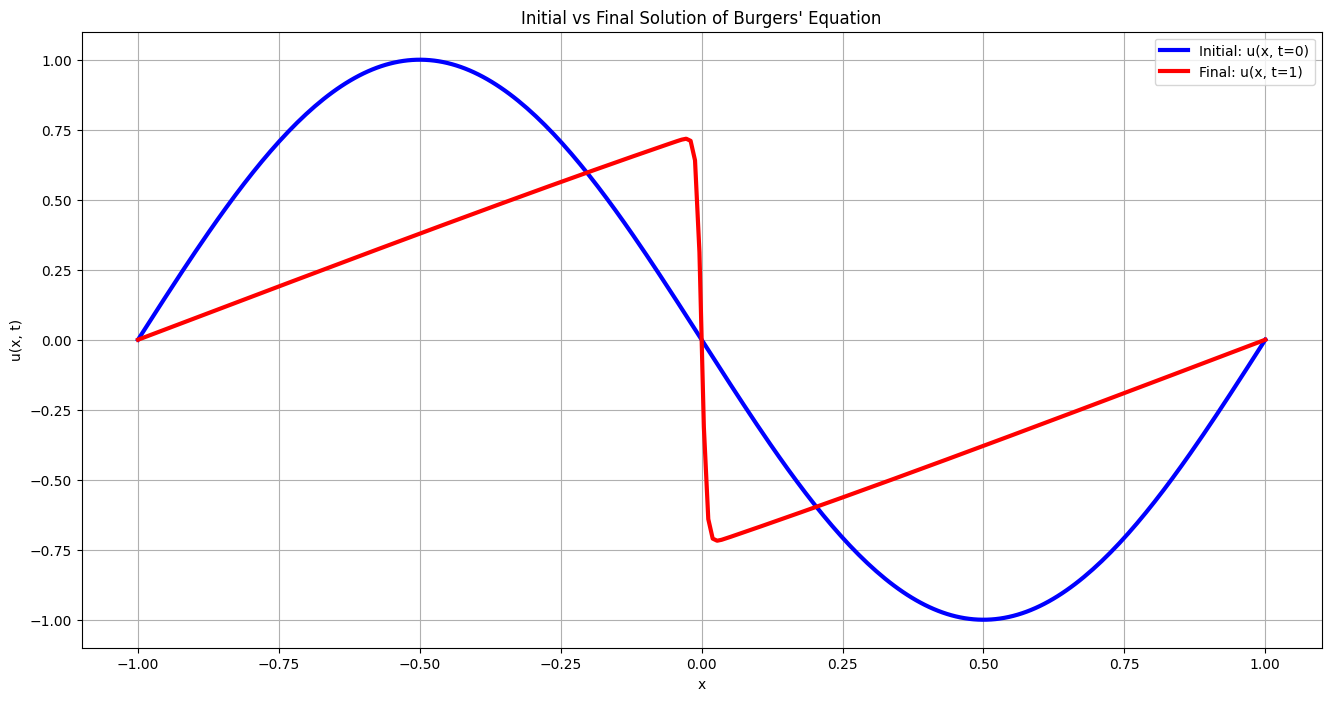

In [6]:
# Plotting
plt.figure(figsize=(16, 8))
plt.plot(x, u0, label="Initial: u(x, t=0)", linewidth=3, c = 'blue')
plt.plot(x, u1, label="Final: u(x, t=1)", linewidth=3, c = 'red')
plt.title("Initial vs Final Solution of Burgers' Equation")
plt.xlabel("x")
plt.ylabel("u(x, t)")
plt.legend()
plt.grid(True)
plt.show()

## **Following code blocks are parts of the full CNO1d model**

###  **`CNO_LReLu`: Custom Activation Layer**

This activation layer is designed to **smooth** and **adjust resolution**. It first **upsamples** the input, applies a non-linearity (LeakyReLU), then **downslices** to the target size.

This helps the network maintain continuity across resolutions when learning functions.

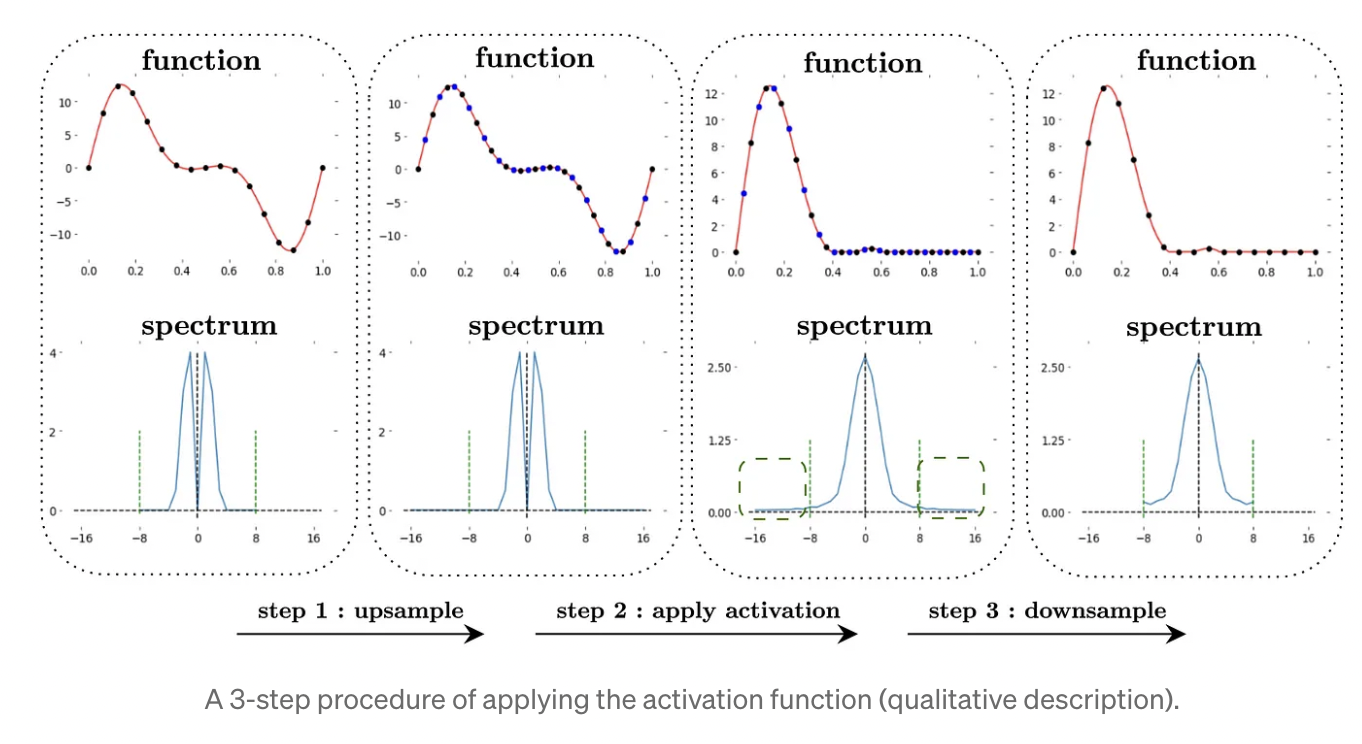

In [7]:
class CNO_LReLu(nn.Module):
    def __init__(self, in_size, out_size):
        """
        This module applies a LeakyReLU activation function while handling spatial upsampling
        and downsampling using bicubic interpolation. It's designed to process 1D signals
        like the solution of Burgers' equation in space (x ∈ [-1, 1]).

        Parameters:
        - in_size  (int): Input spatial resolution. For our Burgers data, this is 256.
        - out_size (int): Target spatial resolution after transformation.
        """
        super(CNO_LReLu, self).__init__()

        self.in_size = in_size            # e.g., 256 for our Burgers' spatial grid
        self.out_size = out_size          # final size after interpolation (can be same or different)
        self.act = nn.LeakyReLU()         # Activation that allows small negative values (avoids dying ReLUs)

    def forward(self, x):
        """
        Forward pass for the activation block.

        Input:
        - x: A tensor of shape (batch_size, channels, in_size), where `in_size` is typically 256

        Process:
        1. Add a dummy dimension so we can use bicubic 2D interpolation
        2. Upsample to double the spatial size → helps smoother gradients
        3. Apply LeakyReLU
        4. Downsample to final desired spatial size

        Output:
        - Tensor of shape (batch_size, channels, out_size)
        """
        # Step 1: Add a dummy dimension → shape: (B, C, 1, 256)
        x = x.unsqueeze(2)

        # Step 2: Upsample to twice the input size → (B, C, 1, 512)
        x = F.interpolate(x, size=(1, 2 * self.in_size), mode="bicubic", antialias=True)

        # Step 3: Apply LeakyReLU activation
        x = self.act(x)

        # Step 4: Downsample to target size → e.g., (B, C, 1, 256)
        x = F.interpolate(x, size=(1, self.out_size), mode="bicubic", antialias=True)

        # Step 5: Remove dummy dimension → (B, C, 256)
        return x[:, :, 0]

### **CNOBlock: Feature Extraction with Spatial Adaptation**

We use **CNOBlock** to extract meaningful features from the input data and gradually transform them through a series of convolutional layers while adapting the spatial resolution. Each `CNOBlock` performs the following sequence of operations:

1. **1D Convolution:** Captures local patterns from the input sequence \( u(x, t) \), such as steep gradients or shock fronts that are characteristic of Burgers' equation solutions.
2. **Batch Normalization (optional):** Stabilizes and accelerates the training process by normalizing feature activations across each batch.
3. **Custom Activation with Interpolation:**
   - **Upsamples** the spatial resolution using bicubic interpolation.
   - Applies **LeakyReLU** to introduce non-linearity.
   - **Downsamples** back to the desired output size, enabling flexible spatial transformations.

This combination allows the model to **operate across multiple spatial scales**, which helps it capture both fine and global features of the solution.

>  In our case, we are learning the mapping from the **initial condition $ u(x, t=0) $** to the **final condition $ u(x, t=1) $**. The ***CNOBlocks*** are responsible for reshaping, filtering, and activating the data in a way that makes this mapping learnable by the network.

In [8]:
class CNOBlock(nn.Module):
    def __init__(self, in_channels, out_channels, in_size, out_size, use_bn=True):
        super(CNOBlock, self).__init__()

        # Step 1: 1D Convolution to extract local features
        # This will reduce or increase the number of feature channels
        self.convolution = nn.Conv1d(
            in_channels,    # Input feature channels (e.g., 1 if input u(x,0), or more in deeper layers)
            out_channels,   # Output feature channels
            kernel_size=3,  # Use a small kernel size to capture local dependencies
            padding=1       # Keeps output the same length as input (so we can stack layers)
        )

        # Step 2: (Optional) Batch Normalization to stabilize learning
        self.batch_norm = nn.BatchNorm1d(out_channels) if use_bn else nn.Identity()

        # Step 3: Nonlinear activation + up/downsampling using bicubic interpolation
        # The CNO_LReLu class handles spatial resizing and applies LeakyReLU
        self.act = CNO_LReLu(in_size, out_size)

    def forward(self, x):
        # Input shape: (batch_size, in_channels, in_size)

        x = self.convolution(x)  # → (batch_size, out_channels, in_size)
        x = self.batch_norm(x)   # → (batch_size, out_channels, in_size)
        x = self.act(x)          # → (batch_size, out_channels, out_size)

        return x  # Final output after convolution, normalization, resizing, and activation

### **LiftProjectBlock: Expanding to Feature Space or Compressing Back**

The **LiftProjectBlock** is used at the **beginning and end** of the CNO model:

- At the **start**, it lifts the input $ u(x, t=0) $ from a low-dimensional space (e.g., 1 channel) to a **higher-dimensional latent feature space**, where learning becomes more expressive.
- At the **end**, it projects the learned features back into the desired **output shape** (e.g., $ u(x, t=1) $).

####  ***Structure:***
1. **CNOBlock:** First applies spatially-aware transformation using convolution and bicubic interpolation with nonlinearity. This enables smooth interpolation while extracting meaningful spatial features.
2. **1D Convolution:** Reduces or expands the number of channels to match the output dimensionality.

####  ***Why It's Important:***
- Neural Operators like CNO operate better in high-dimensional feature spaces. So we **lift** the data initially.
- Once feature transformation is complete, we **project** back to the original function space.

> In our Burgers' equation example, this block helps transform the initial condition $ u(x, t=0) $ into a richer representation and then back from features to a final solution $ u(x, t=1) $.

In [9]:
class LiftProjectBlock(nn.Module):
    def __init__(self, in_channels, out_channels, size, latent_dim=64):
        super(LiftProjectBlock, self).__init__()

        # Step 1: Lift input into a richer feature space using a CNOBlock
        # - `in_channels`: number of input channels (e.g., 1 for scalar input u(x))
        # - `latent_dim`: intermediate hidden feature size after lifting
        # - `size`: spatial resolution (e.g., 256 for 256 x-points)
        # - `use_bn=False`: BatchNorm is skipped in lifting/projecting layers for simplicity
        self.inter_CNOBlock = CNOBlock(
            in_channels=in_channels,      # Input channel size (e.g., 1 for u(x))
            out_channels=latent_dim,      # Lift to latent feature space
            in_size=size,                 # Input spatial size (e.g., 256)
            out_size=size,                # Output spatial size remains unchanged
            use_bn=False                  # No batch normalization here
        )

        # Step 2: Convolution to map latent_dim → out_channels (final feature/channel size)
        # This adjusts the channel dimension for further layers (e.g., encoder or final output)
        self.convolution = nn.Conv1d(
            in_channels=latent_dim,       # From latent space
            out_channels=out_channels,    # Desired output channel dimension
            kernel_size=3,                # Standard kernel size
            padding=1                     # Keeps output same size as input
        )

    def forward(self, x):
        # Apply the CNO block to lift input features
        x = self.inter_CNOBlock(x)

        # Apply final convolution to set correct output channel dimension
        x = self.convolution(x)

        # Return the lifted/projected feature map
        return x

###  **Residual Blocks — Why Do We Use Them?**

In deep learning, using many layers allows a model to learn complex mappings. However, this can introduce challenges like:

- **Vanishing gradients**: Updates become too small to train deep layers effectively.
- **Degradation**: Deeper models sometimes perform worse.
- **Loss of detail**: Subtle features may get lost as the depth increases.

To overcome this, we use **Residual Blocks**, which introduce a *skip connection*:

$
\text{Output} = \text{Input} + \mathcal{F}(\text{Input})
$

Here, $ \mathcal{F} $ is a small transformation (e.g., convolution + activation) and the original input is added back. This helps preserve important features and improves training.

---

###  ***What Does It Do in Our Model?***

In our `CNO1d` model for solving **Burgers’ equation**, residual blocks:

- Help the model **retain information** from earlier layers.
- Enable learning **deeper representations** of the function.
- Improve **training stability and efficiency** through skip connections.
- Allow the network to **refine predictions** at each step without forgetting the base state.

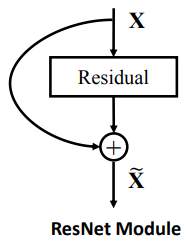

In [10]:
class ResidualBlock(nn.Module):
    def __init__(self, channels, size, use_bn=True):
        super(ResidualBlock, self).__init__()

        # First convolutional layer:
        # Applies a 1D convolution to extract features from the input
        self.conv1 = nn.Conv1d(
            in_channels=channels,       # Number of input channels
            out_channels=channels,      # Output channels same as input for skip connection
            kernel_size=3,              # Standard kernel for local context
            padding=1                   # Padding to preserve spatial dimensions
        )

        # Second convolutional layer:
        # Again uses the same number of channels to maintain consistency
        self.conv2 = nn.Conv1d(
            in_channels=channels,
            out_channels=channels,
            kernel_size=3,
            padding=1
        )

        # Batch normalization layers (optional)
        # Normalize activations between layers for stability during training
        self.bn1 = nn.BatchNorm1d(channels) if use_bn else nn.Identity()
        self.bn2 = nn.BatchNorm1d(channels) if use_bn else nn.Identity()

        # Custom LeakyReLU-based activation with spatial resizing
        self.act = CNO_LReLu(in_size=size, out_size=size)

    def forward(self, x):
        # Step 1: First conv → BN → activation
        out = self.conv1(x)         # First convolution
        out = self.bn1(out)         # Optional batch normalization
        out = self.act(out)         # Non-linear activation with interpolation

        # Step 2: Second conv → BN
        out = self.conv2(out)       # Second convolution
        out = self.bn2(out)         # Optional batch normalization

        # Step 3: Skip connection (residual addition)
        return x + out              # Add input to output (residual connection)

### **ResNet Blocks**

### ***Where ResNet Blocks Are Used:***

In the `CNO1d` model:

- ResNet blocks are used in **each encoder stage** to improve feature extraction.
- A **bottleneck ResNet block** is used in the middle of the network (the "neck") to handle compressed features.

This design ensures better learning and generalization for complex mappings like PDE solutions.

In [11]:
class ResNet(nn.Module):
    def __init__(self, channels, size, num_blocks, use_bn=True):
        super(ResNet, self).__init__()

        # Stack multiple residual blocks together using nn.Sequential
        # Each block helps the model learn better representations with skip connections
        self.blocks = nn.Sequential(
            *[ResidualBlock(channels, size, use_bn) for _ in range(num_blocks)]
            # Creates a list of `num_blocks` ResidualBlock layers
            # All blocks use the same number of input/output channels
        )

    def forward(self, x):
        # Pass input through the full stack of residual blocks
        return self.blocks(x)

## **Step 03: Defining CNO1d Architecture**

This class implements the **Convolutional Neural Operator (CNO1d)**, which learns a mapping from **functions to functions** — specifically, from the **initial condition** $ u(x, t=0) $ to the **final state** $ u(x, t=1) $ for Burgers' equation.

---

### ***Main Components of the Architecture:***

1. **Lifting Layer**:
    - `LiftProjectBlock` lifts the 1D input function to a higher-dimensional feature space.
    - Input: $ (B, 1, 256) $ → Output: $ (B, \text{lift\_dim}, 256) $

2. **Encoder**:
    - Applies a series of `CNOBlock` layers, each reducing spatial resolution (downsampling).
    - Before each downsampling, a `ResNet` block refines features at that level.
    - Skip connections are stored for later use in the decoder.

3. **Neck (Bottleneck)**:
    - Applies a deeper ResNet (`res_net_neck`) at the lowest resolution to extract global information.

4. **ED Expansion Layers**:
    - Adjust spatial sizes of features to match during decoding.
    - Allows alignment for concatenation with corresponding encoder features (skip connections).

5. **Decoder**:
    - Reconstructs the function step-by-step using the stored skip connections.
    - Combines current decoder feature with aligned encoder feature via `torch.cat`.

6. **Projection Layer**:
    - Reduces the channel dimension back to the output space (e.g., 1 channel for $ u(x, t=1) $).

---

### ***Flow of Forward Pass:***

- **Step 1**: Lift input to feature space
- **Step 2**: Pass through encoder (`ResNet` + `CNOBlock`)
- **Step 3**: Apply neck `ResNet` block
- **Step 4**: Decode using skip connections and upsampling
- **Step 5**: Project back to target output shape

---

### ***Example Mapping:***

Given:
- $ u(x, 0) $ as input of shape $ (B, 1, 256) $

The model outputs:
- $ u(x, 1) $ of shape $ (B, 1, 256) $, after learning the PDE dynamics implicitly.

In [12]:
class CNO1d(nn.Module):
    def __init__(self, in_dim, out_dim, size, N_layers, N_res=4, N_res_neck=4,
                 channel_multiplier=16, use_bn=True):
        super(CNO1d, self).__init__()

        # --------- Basic setup ---------
        self.N_layers = N_layers                          # Number of encoder/decoder layers
        self.in_dim = in_dim                              # Number of input channels (e.g., 1 for u0)
        self.out_dim = out_dim                            # Number of output channels (e.g., 1 for u1)
        self.channel_multiplier = channel_multiplier      # Controls channel size growth
        self.lift_dim = channel_multiplier // 2           # First lifting layer output channels

        # --------- Channel sizes ---------
        # encoder_features = number of channels in encoder
        self.encoder_features = [self.lift_dim]
        for i in range(N_layers):
            self.encoder_features.append(2**i * channel_multiplier)

        # decoder input and output channels
        self.decoder_features_in = self.encoder_features[1:][::-1]  # reversed for decoder
        self.decoder_features_out = self.encoder_features[:-1][::-1]

        # double decoder input channels for concatenation with skip connections
        for i in range(1, N_layers):
            self.decoder_features_in[i] *= 2

        # --------- Spatial sizes ---------
        # encoder sizes = how resolution changes in encoder
        self.encoder_sizes = [size // 2**i for i in range(N_layers + 1)]
        self.decoder_sizes = [size // 2**(N_layers - i) for i in range(N_layers + 1)]

        # --------- Lifting & Projection blocks ---------
        self.lift = LiftProjectBlock(in_channels=in_dim,
                                     out_channels=self.encoder_features[0],
                                     size=size)

        self.project = LiftProjectBlock(
            in_channels=self.encoder_features[0] + self.decoder_features_out[-1],
            out_channels=out_dim,
            size=size
        )

        # --------- Encoder blocks ---------
        self.encoder = nn.ModuleList()
        for i in range(N_layers):
            self.encoder.append(
                CNOBlock(self.encoder_features[i], self.encoder_features[i + 1],
                         self.encoder_sizes[i], self.encoder_sizes[i + 1],
                         use_bn=use_bn)
            )

        # --------- ED Expansion blocks ---------
        self.ED_expansion = nn.ModuleList()
        for i in range(N_layers + 1):
            self.ED_expansion.append(
                CNOBlock(self.encoder_features[i], self.encoder_features[i],
                         self.encoder_sizes[i], self.decoder_sizes[N_layers - i],
                         use_bn=use_bn)
            )

        # --------- Decoder blocks ---------
        self.decoder = nn.ModuleList()
        for i in range(N_layers):
            self.decoder.append(
                CNOBlock(self.decoder_features_in[i], self.decoder_features_out[i],
                         self.decoder_sizes[i], self.decoder_sizes[i + 1],
                         use_bn=use_bn)
            )

        # --------- ResNet blocks in encoder and neck ---------
        self.res_nets = nn.Sequential(*[
            ResNet(self.encoder_features[i], self.encoder_sizes[i],
                   num_blocks=N_res, use_bn=use_bn)
            for i in range(N_layers)
        ])

        self.res_net_neck = ResNet(self.encoder_features[N_layers],
                                   self.encoder_sizes[N_layers],
                                   num_blocks=N_res_neck,
                                   use_bn=use_bn)

    def forward(self, x):
        # --------- Step 1: Lift input ---------
        x = self.lift(x)     # (B, in_dim, 256) → (B, lift_dim, 256)
        skip = []

        # --------- Step 2: Encoder path ---------
        for i in range(self.N_layers):
            y = self.res_nets[i](x)   # apply ResNet
            skip.append(y)            # save skip connection
            x = self.encoder[i](x)    # downsample

        # --------- Step 3: Neck ---------
        x = self.res_net_neck(x)      # apply ResNet bottleneck

        # --------- Step 4: Decoder path ---------
        for i in range(self.N_layers):
            # match resolution of encoder output
            if i == 0:
                x = self.ED_expansion[self.N_layers - i](x)
            else:
                x = torch.cat((x, self.ED_expansion[self.N_layers - i](skip[-i])), dim=1)

            x = self.decoder[i](x)

        # --------- Step 5: Final projection ---------
        x = torch.cat((x, self.ED_expansion[0](skip[0])), dim=1)
        x = self.project(x)

        return x

## **Step 04: Training the CNO1d Model**

In this step, we train our `CNO1d` model to learn the mapping from the **initial condition** $ u(x, t=0) $ to the **final solution** $ u(x, t=1) $ of the Burgers' equation.

---

### ***1. Data Preparation***

We extract:
- `u0` = initial condition: $ u(x, 0) $
- `u1` = final condition: $ u(x, 1) $

These are reshaped into the required format:
- Shape: `[batch_size, channels, spatial_points]`
- For example: `[1, 1, 256]` (batch size = 1, 1 channel, 256 spatial grid points)

We then convert them to PyTorch tensors and move them to the appropriate device (CPU or GPU).

---

### ***2. Dataset and DataLoader***

We use `TensorDataset` and `DataLoader` to organize the data for training. Here, even though we only have one pair (`u0 → u1`), batching is enabled so we can extend this later to more samples.

---

### ***3. Model Initialization***

We initialize the `CNO1d` model with:
- `in_dim=1` and `out_dim=1` since both input and output have 1 channel (scalar function).
- `size=256` spatial points.
- `N_layers=2`: two encoder/decoder stages.
- `N_res=2`: two residual blocks per layer.
- `N_res_neck=2`: two residual blocks in the bottleneck layer.
- `channel_multiplier=16`: base channel size that grows with depth.
- `use_bn=True`: enables batch normalization.

---

### ***4. Loss Function and Optimizer***

- **Loss**: Mean Squared Error (MSE) to measure prediction error.
- **Optimizer**: Adam optimizer with learning rate $ 10^{-3} $.

---

### ***5. Training Loop***

- For `epochs=100`, we iterate through the dataset.
- For each batch:
  - Compute prediction with `model(xb)`
  - Calculate loss with respect to `yb`
  - Backpropagate gradients with `loss.backward()`
  - Update model parameters with `optimizer.step()`
- Track and print loss at each epoch.

---

> By the end of training, the model should learn to approximate $ u(x, 1) $ from the given $ u(x, 0) $ — learning the dynamics of the Burgers' equation purely from data.

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

u0 = u[:, 0].reshape(1, 1, 256)  # [batch, channels, spatial]
u1 = u[:, -1].reshape(1, 1, 256)

x_train = torch.tensor(u0, dtype=torch.float32).to(device)
y_train = torch.tensor(u1, dtype=torch.float32).to(device)


# --- Create dataset and dataloader ---
dataset = TensorDataset(x_train, y_train)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# --- Instantiate model ---
model = CNO1d(
    in_dim=1,
    out_dim=1,
    size=256,
    N_layers=2,
    N_res=2,
    N_res_neck=2,
    channel_multiplier=16,
    use_bn=True
).to(device)

# --- Define loss and optimizer ---
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

# --- Training Loop ---
epochs = 100
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for xb, yb in dataloader:
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.6f}")

Epoch 1/100, Loss: 0.263757
Epoch 2/100, Loss: 0.186251
Epoch 3/100, Loss: 0.131134
Epoch 4/100, Loss: 0.103226
Epoch 5/100, Loss: 0.086152
Epoch 6/100, Loss: 0.072216
Epoch 7/100, Loss: 0.058761
Epoch 8/100, Loss: 0.048916
Epoch 9/100, Loss: 0.039751
Epoch 10/100, Loss: 0.031207
Epoch 11/100, Loss: 0.025309
Epoch 12/100, Loss: 0.020799
Epoch 13/100, Loss: 0.015908
Epoch 14/100, Loss: 0.013775
Epoch 15/100, Loss: 0.014033
Epoch 16/100, Loss: 0.014087
Epoch 17/100, Loss: 0.013046
Epoch 18/100, Loss: 0.011913
Epoch 19/100, Loss: 0.009948
Epoch 20/100, Loss: 0.007916
Epoch 21/100, Loss: 0.006142
Epoch 22/100, Loss: 0.004979
Epoch 23/100, Loss: 0.004230
Epoch 24/100, Loss: 0.004139
Epoch 25/100, Loss: 0.003996
Epoch 26/100, Loss: 0.003565
Epoch 27/100, Loss: 0.003274
Epoch 28/100, Loss: 0.002698
Epoch 29/100, Loss: 0.002216
Epoch 30/100, Loss: 0.001708
Epoch 31/100, Loss: 0.001459
Epoch 32/100, Loss: 0.001229
Epoch 33/100, Loss: 0.001173
Epoch 34/100, Loss: 0.001193
Epoch 35/100, Loss: 0.0

## **Step 05: Inference and Visualization**

After training the model, we now evaluate its performance by:

---

### ***1. Switching to Evaluation Mode***

We set the model to evaluation mode using `model.eval()` and disable gradient computation using `torch.no_grad()`.

This ensures:
- No unnecessary gradient tracking (saves memory)
- BatchNorm and Dropout (if any) behave consistently during inference

---

### ***2. Making Predictions***

We pass the trained input `u(x, t=0)` into the model:
- Get the **predicted solution** $ \hat{u}(x, t=1) $
- Compare it to the **true solution** $ u(x, t=1) $

---

### ***3. Plotting Results***

We visualize:
- The **true solution** at $ t = 1 $
- The **predicted solution** from the trained CNO1d model

A successful model should generate a predicted curve that closely matches the ground truth.

This comparison helps us verify if the model correctly learned the nonlinear dynamics of the **Burgers' equation**.

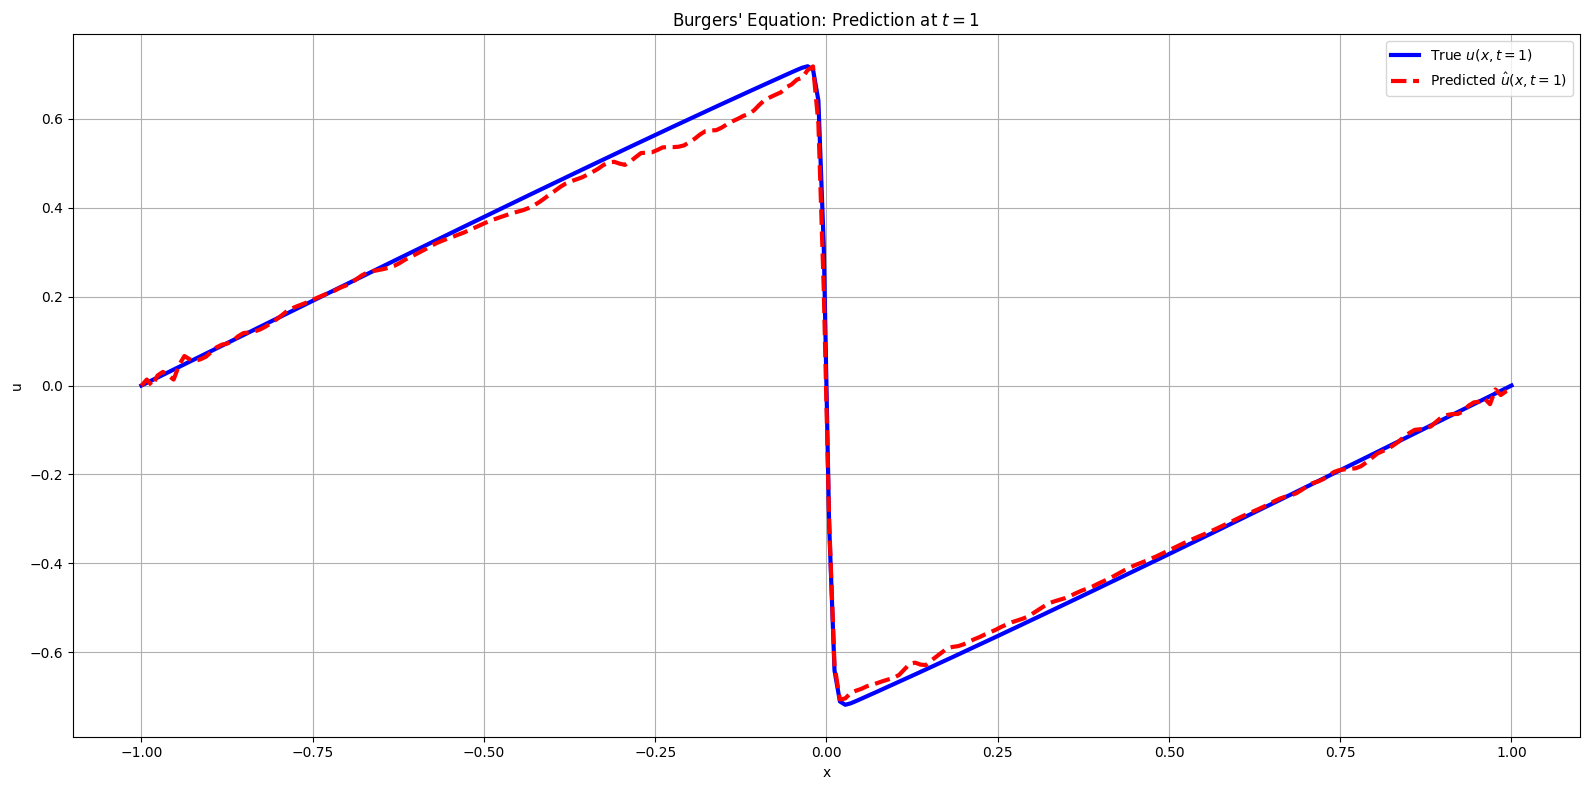

In [14]:
# === Switch to evaluation mode ===
model.eval()
with torch.no_grad():
    y_pred = model(x_train).cpu().numpy()  # Predicted [batch, 1, 256]
    y_true = y_train.cpu().numpy()         # Ground truth

# === Plotting ===
plt.figure(figsize=(16, 8))
plt.plot(x, y_true[0, 0], label='True $u(x, t=1)$', linewidth=3, c = 'blue')
plt.plot(x, y_pred[0, 0], '--', label='Predicted $\\hat{u}(x, t=1)$', linewidth=3, c = 'red')
plt.xlabel("x")
plt.ylabel("u")
plt.title("Burgers' Equation: Prediction at $t=1$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()